In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import sirf.STIR as STIR
STIR.AcquisitionData.set_storage_scheme('memory')

In [2]:
data_path = '/mnt/share/petric/Siemens_mMR_NEMA_IQ'

In [3]:
STIR.set_verbosity(1)

In [4]:
#%% some handy function definitions
def plot_2d_image(idx,vol,title,clims=None,cmap="viridis"):
    """Customized version of subplot to plot 2D image"""
    plt.subplot(*idx)
    plt.imshow(vol,cmap=cmap)
    if not clims is None:
        plt.clim(clims)
    plt.colorbar(shrink=.4)
    plt.title(title)
    plt.axis("off")

In [5]:
def create_acq_model_and_obj_fun(acquired_data, additive_term, mult_factors, template_image):
    '''
    Create an acquisition model and objective function, corresponding to the given data.
    '''
    # We could construct this by hand here, but instead will just use `partitioner.data_partition`
    # with 1 subset, which will then do the work for us.
    num_subsets = 1
    _, acq_models, obj_funs = partitioner.data_partition(acquired_data, additive_term, mult_factors, num_subsets, initial_image=template_image)
    return (acq_models[0], obj_funs[0])

In [6]:
def rdp_step_size_den (inpImm_,sDir_,kappa_,eps_,pixS_,alpha_=0):
    rdpG_ = np.zeros_like(inpImm_)
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
                    print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                shiftSI_ = np.roll(sDir_,(zs,xs,ys),axis=(0,1,2))                
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                    shiftSI_[-1,:,:] = sDir_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]
                    shiftSI_[0,:,:] = sDir_[0,:,:]

                tempW = pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)             
                rdpG_ += tempW*(sDir_ - shiftSI_)*(inpImm_ + 3 * shiftImm_ + 2* eps_ + 2* np.abs(inpImm_-shiftImm_)) /(inpImm_+ shiftImm_ + 2*np.abs(inpImm_-shiftImm_ )+eps_)** 2 
    return rdpG_    

In [7]:
def rdp_grad (inpImm_,kappa_,eps_,pixS_):
    rdpG_ = np.zeros_like(inpImm_)
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
                    print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]

                tempW = pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)             
                rdpG_ += tempW*(inpImm_ - shiftImm_)*(inpImm_ + 3 * shiftImm_ + 2* eps_ + 2* np.abs(inpImm_-shiftImm_)) /(inpImm_+ shiftImm_ + 2*np.abs(inpImm_-shiftImm_ )+eps_)** 2 
    return rdpG_
    


In [ ]:
def rdp_grad_sirf (inpImm_,kappa_,eps_,pixS_):
    rdpG_ = np.zeros_like(inpImm_)
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
                    print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]

                tempW = pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)             
                rdpG_ += tempW*(inpImm_ - shiftImm_)*(inpImm_ + 3 * shiftImm_ + 2* eps_ + 2* np.abs(inpImm_-shiftImm_)) /(inpImm_+ shiftImm_ + 2*np.abs(inpImm_-shiftImm_ )+eps_)** 2 
    return rdpG_
    

In [53]:
def rdp_step_size (inpImm_,sDir_,kappa_,eps_,pixS_,alpha_=0):
    ssNum = 0
    ssDen = 0
   # denImm_ = inpImm_ + alpha * sDir_
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
    #                print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                shiftSI_ = np.roll(sDir_,(zs,xs,ys),axis=(0,1,2))                
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                    shiftSI_[-1,:,:] = sDir_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]
                    shiftSI_[0,:,:] = sDir_[0,:,:]
                wI = 1/(inpImm_ + shiftImm_ + alpha_ * (sDir_ + shiftSI_) + 2 * np.abs(inpImm_-shiftImm_+ alpha_ * (sDir_ - shiftSI_)) + eps_)
                wI *= pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
                ssNum -= np.matmul((inpImm_-shiftImm_).flatten().T,((sDir_-shiftSI_)*wI).flat)
                ssDen += np.matmul((shiftSI_-sDir_).flatten().T,((shiftSI_-sDir_)*wI).flat)
    return ssNum,ssDen

In [9]:
def rdp_step_size_bis (inpImm_,sDir_,kappa_,eps_,pixS_,alpha_=0):
    pass

In [10]:
image = STIR.ImageData(os.path.join(data_path, 'OSEM_image.hv'))

In [11]:
kappa = STIR.ImageData(os.path.join(data_path, 'kappa.hv'))

In [54]:
stir_prior = STIR.CudaRelativeDifferencePrior ()

In [55]:
stir_prior.set_epsilon(image.max()*1e-3)
stir_prior.set_penalisation_factor(1/700)
stir_prior.set_kappa(kappa)
stir_prior.set_up(image)

In [15]:
# stirG = stir_prior.gradient(image)

In [56]:
inpImage = image.as_array()

# Reconstruction

In [57]:
acq_model = STIR.AcquisitionModelUsingParallelproj()
template = STIR.AcquisitionData(os.path.join(data_path, 'prompts.hs'))
multCorr = STIR.AcquisitionData(os.path.join(data_path,'mult_factors.hs'))
addCorr = STIR.AcquisitionData(os.path.join(data_path,'additive_term.hs'))
acq_model.set_up(template, image)

In [21]:
print ('num: {:.1e} den: {:.1e}'.format(1.,2.))

num: 1.0e+00 den: 2.0e+00


In [22]:
image.fill(ndi.gaussian_filter(inpImage,1))

NameError: name 'ndi' is not defined

# Osem

In [ ]:
sens = acq_model.backward(multCorr)

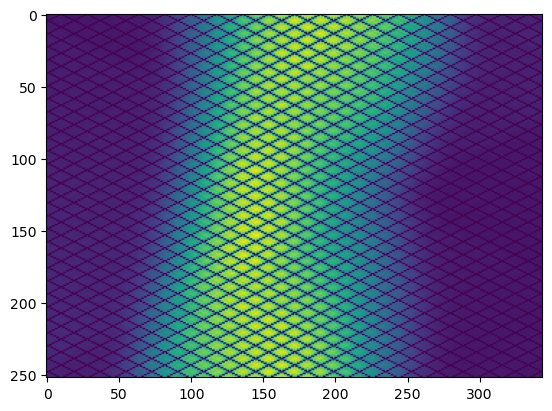

In [860]:
plt.imshow((multCorr*addCorr).as_array()[0,72,:,:])

In [866]:
nIt = 10
#
for itIdx in range(nIt):
    curFP = acq_model.forward(image)
    curFP +=addCorr
    curFP *= multCorr
    
    upF = acq_model.backward(multCorr*template/curFP)
    upF /= sens
    image *= upF

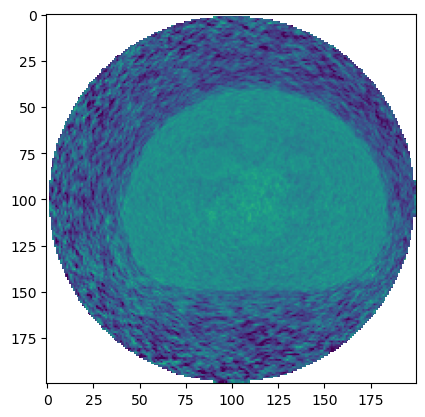

In [869]:
plt.imshow(upF.as_array()[72,:,:],vmin=.8,vmax=1.2)

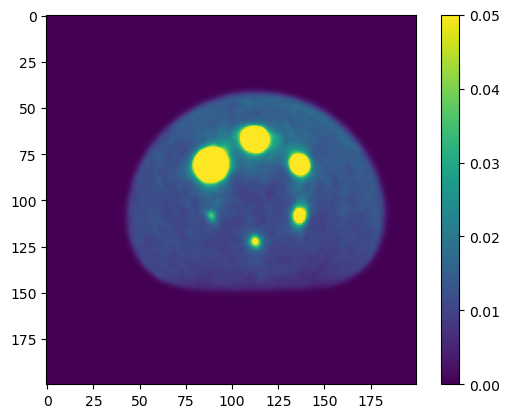

In [626]:
plt.imshow(image.as_array()[72,:,:],vmax=.05)
plt.colorbar()

(0.0, 0.35)

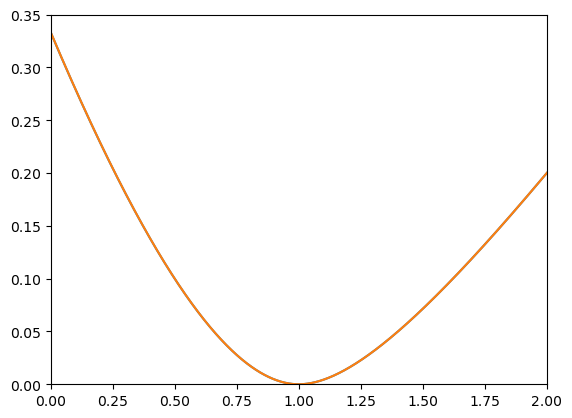

In [16]:
xv = np.arange(0,10,0.001)
yv1 = (1-xv)**2 / (1+xv + 2 * np.abs(1-xv)+1e-3)
plt.plot (xv,yv1)
yv1 = (1-xv)**2 / (1+xv + 2 * np.abs(1-xv))
plt.plot (xv,yv1)
plt.xlim(0,2)

# yv1 = (1-xv)**2 / (1+xv + 0 * np.abs(1-xv))
# plt.plot (xv,yv1)
# yv1 = (1-xv)**2 / (1+xv + 5 * np.abs(1-xv))
# plt.plot (xv,yv1)
plt.ylim((0,.35))

# PGA

In [58]:
tFP = acq_model.forward(image)
tFP += addCorr
tFP *= multCorr
rMax = addCorr.max()* 1e-6
tFP += rMax
myK = acq_model.backward(multCorr*multCorr/tFP)

In [200]:
image.fill(inpImage)

In [60]:
import scipy.ndimage as ndi
mask = kappa.as_array()<1
mask = ndi.binary_dilation(mask)
mask = 1 - mask
#maskImm = STIR.ImageData(

In [61]:
maskS = image.get_uniform_copy(0)
maskS.fill(mask)

In [ ]:
nIt = 200
addCorr += rMax
fwdProj = acq_model.forward(image)
fwdProj += addCorr
fwdProj *= multCorr 
fwdProj += rMax
recItV_2 = np.zeros((nIt,) + inpImage.shape)
betaPen =  1/700
penEps = 1e-3*inpImage.max()

for itIdx in range(nIt):
    gradSino =  template/fwdProj - 1
    gradI = acq_model.backward(gradSino*multCorr)
#    gradI = grad.as_array()
#    gradPen = betaPen*rdp_grad(image.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    grad = gradI - stir_prior.gradient(image)
 #   grad.fill(gradI-gradPen)
    sDir = grad*maskS / (myK + 1e-10)

    # if itIdx>0:
    #     beta = (grad-gradP).dot(sDir)/gradP.dot(prevSDir)
    #     sDir += beta * prevSDir 
    
    sDirImm = sDir.as_array()

    # prevSDir = sDir.clone()
    # gradP = grad.clone()

    #   sDirImm[mask]=0
 #   sDir.fill(np.nan_to_num(sDirImm))
    #sDir
    fPsDir = acq_model.forward(sDir)*multCorr
#    ssNum = np.matmul(sDir.as_array().flatten().T,gradI.flatten())
#    sinW = (fPsDir.as_array()/fwdProj.as_array())
#    sinW[np.isnan(sinW)]=0
#    ssDen = np.matmul(fPsDir.as_array().flatten().T,sinW.flatten())
    ssNum = sDir.dot(gradI)
    ssDen = fPsDir.dot(fPsDir/fwdProj)
    
    print ('num: {:.1e} den: {:.1e}'.format(ssNum,ssDen))
    ssTomo = ssNum/ssDen
  #  penSSNum = np.matmul(sDirImm.flatten().T,gradPen.as_array())
  #  penSSDen = np.matmul(sDirImm.flatten().T,rdp_grad(sDi.as_array(),kappa.as_array(),penEps,image.voxel_sizes()))
    penSSNum, penSSDen = rdp_step_size(image.as_array(),sDir.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    ss = (ssNum+betaPen*penSSNum)/(ssDen+betaPen*penSSDen)
    image += ss*sDir
    fwdProj += ss*fPsDir

# UNCOMMENT to update sinogram in each iteration
    
    # imArr = image.as_array()
    # imArr[imArr<0]=0
    # imArr[np.isnan(imArr)] = 0
    # image.fill(imArr)
    # fwdProj = acq_model.forward(image)
    # fwdProj += addCorr  
    # fwdProj *= multCorr 
    # fwdProj += rMax

  #  fwdProj+= ss/ssDen*fPsDir
    recItV_2[itIdx,:,:,:] = image.as_array()
    

num: 2.1e+05 den: 7.3e+07
num: 1.5e+05 den: 7.1e+07
num: 8.9e+04 den: 7.0e+07
num: 5.8e+04 den: 6.9e+07
num: 9.3e+03 den: 6.9e+07
num: -1.1e+04 den: 6.8e+07
num: -5.0e+04 den: 6.7e+07
num: -6.3e+04 den: 6.6e+07
num: -9.7e+04 den: 6.6e+07
num: -1.1e+05 den: 6.5e+07
num: -1.3e+05 den: 6.4e+07
num: -1.4e+05 den: 6.4e+07
num: -1.7e+05 den: 6.3e+07
num: -1.7e+05 den: 6.2e+07
num: -1.9e+05 den: 6.2e+07
num: -2.0e+05 den: 6.1e+07
num: -2.2e+05 den: 6.0e+07
num: -2.2e+05 den: 6.0e+07
num: -2.4e+05 den: 5.9e+07
num: -2.4e+05 den: 5.9e+07
num: -2.6e+05 den: 5.8e+07
num: -2.6e+05 den: 5.7e+07
num: -2.7e+05 den: 5.7e+07
num: -2.7e+05 den: 5.6e+07
num: -2.9e+05 den: 5.6e+07
num: -2.9e+05 den: 5.5e+07
num: -3.0e+05 den: 5.5e+07
num: -3.0e+05 den: 5.4e+07
num: -3.2e+05 den: 5.4e+07
num: -3.1e+05 den: 5.3e+07
num: -3.3e+05 den: 5.3e+07
num: -3.3e+05 den: 5.2e+07
num: -3.4e+05 den: 5.2e+07
num: -3.4e+05 den: 5.1e+07
num: -3.5e+05 den: 5.1e+07
num: -3.5e+05 den: 5.0e+07
num: -3.6e+05 den: 5.0e+07
num: -

In [664]:
ssNum/(betaPen*penSSNum)

-0.04283982740424812

In [105]:
ssTomo, ss

(-0.010145578, 7.253252445396138e-05)

In [106]:
ssDen/(betaPen*penSSDen)

0.0006629442771607258

In [554]:
rdp_step_size(inpImage,sDir.as_array(),kappa.as_array(),penEps,image.voxel_sizes(),alpha_=-0.008)

continuing


(-15899803392.0, 1942983315456.0)

In [555]:
297705281./65286291328.0

0.004559996822369968

In [556]:
pG = rdp_grad(inpImage,kappa.as_array(),penEps,image.voxel_sizes())

continuing


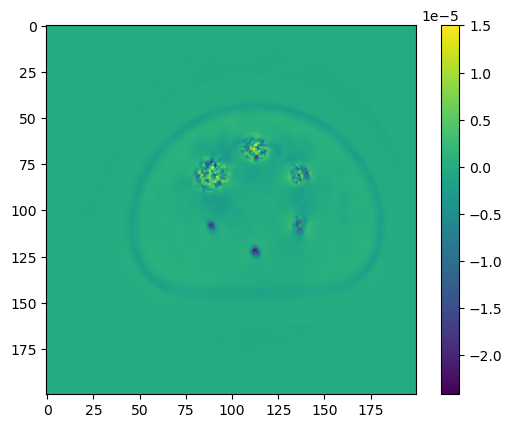

In [202]:
plt.imshow(ss*sDirImm[72,:,:])
plt.colorbar()

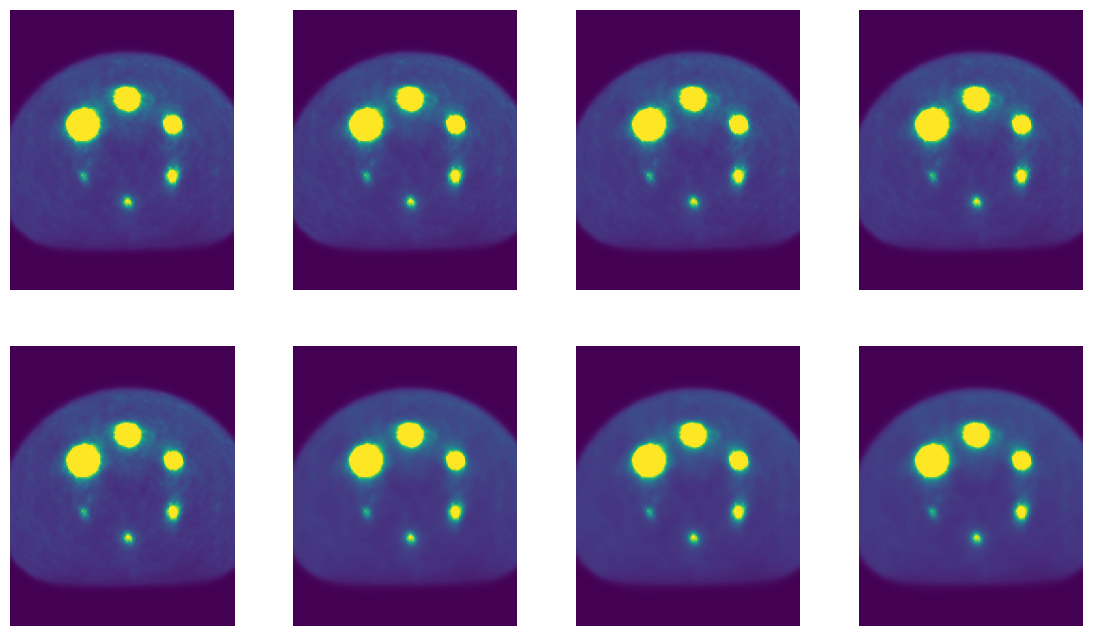

In [223]:
plt.figure(figsize=(14,8))
for itIdx in range(4):
    plt.subplot(2,4,itIdx+1)
    plt.imshow(recItV[itIdx,72,20:-30,50:-30],vmax=.07)
    plt.axis('off')
    plt.subplot(2,4,itIdx+5)
    plt.imshow(recItV_CG[itIdx,72,20:-30,50:-30],vmax=.07)    
    plt.axis('off')

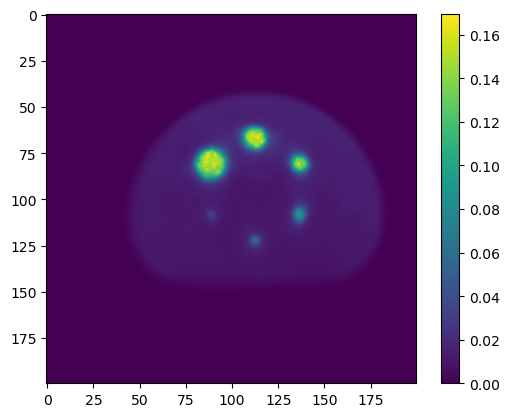

In [203]:
plt.imshow((image.as_array())[72,:,:]) #,vmax=.16)
plt.colorbar()

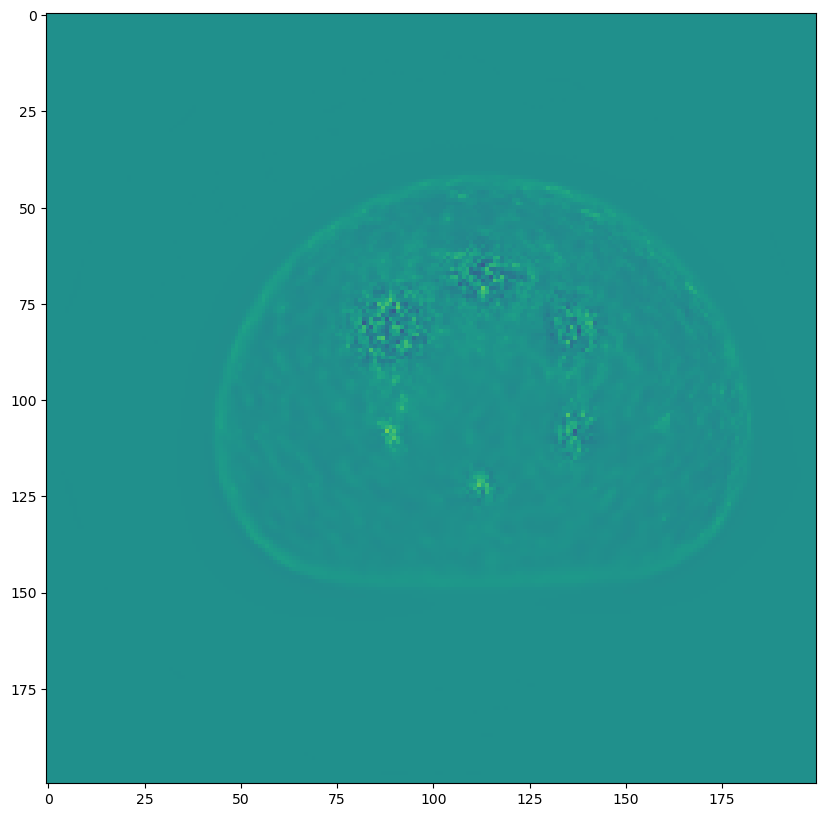

In [195]:
plt.figure(figsize=(10,10))
# plt.subplot(121)
# #plt.imshow((image.as_array())[72,:,:],vmin=0,vmax=.09)
# plt.imshow(recItV[-1,72,:,:],vmin=0,vmax=.12)
# #plt.imshow(inpImage[72,:,:]-0.004*sDirImm[72,:,:],vmin=0,vmax=.2)
# plt.subplot(122)
# plt.imshow(recItV_CG[-1,72,:,:],vmin=0,vmax=.12)
plt.imshow(recItV[9,72,:,:]-recItV_CG[9,72,:,:],vmin=-0.02,vmax=.02)

In [119]:
recItV_CG = recItV.copy()

Text(0, 0.5, '||i - i_inf||^2')

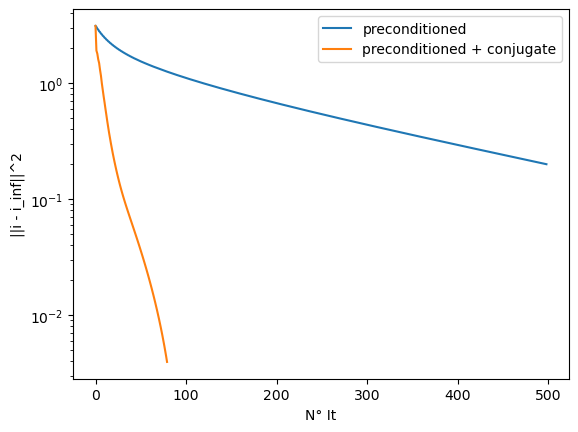

In [209]:
dV = np.sum(np.sum(np.sum((recItV[:-1,:,:,:]-np.expand_dims(recItV_CG[-1,:,:,:],axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)
#dV = np.sum(np.sum(np.sum((recItV_CG[:-4,:,:,:]-np.expand_dims(recItV[-1,:,:,:],axis=0))**2,axis=-1),axis=-1),axis=-1)
dV = np.sum(np.sum(np.sum((recItV_CG[:-20,:,:,:]-np.expand_dims(recItV_CG[-1,:,:,:],axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)

# dV = np.sum(np.sum(np.sum((recItV[:-120,:,:,:]-np.expand_dims(recItV[-1,:,:,:],axis=0))**2,axis=-1),axis=-1),axis=-1)
# plt.plot(dV)
#dV = np.sum(np.sum(np.sum((recItV_CG[:-20,:,:,:]-np.expand_dims(recItV[-1,:,:,:],axis=0))**2,axis=-1),axis=-1),axis=-1)
#plt.plot(dV)
#plt.xlim(0,20)
#plt.ylim(1e-3,4)
plt.yscale('log')
plt.legend(['preconditioned','preconditioned + conjugate'])
plt.xlabel('N° It')
plt.ylabel('Difference vector')


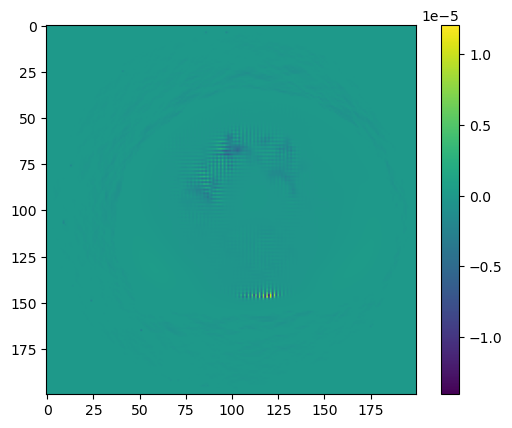

In [111]:
plt.imshow(ss*sDir.as_array()[115,:,:])
plt.colorbar()

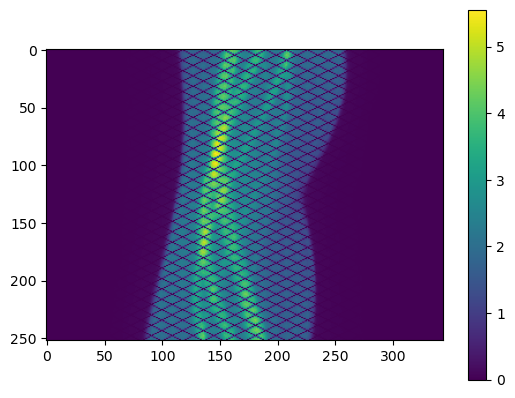

In [666]:
slIdx +=1
plt.imshow(tFP.as_array()[0,slIdx,:,:])
plt.colorbar()

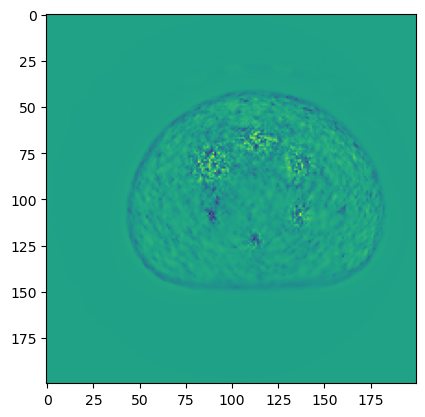

In [674]:
plt.imshow(sDir.as_array()[72,:,:]) #,vmax=400)

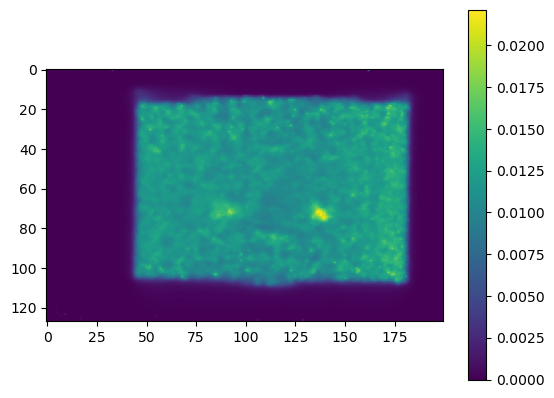

In [675]:
plt.imshow(image.as_array()[:,100,:]) #,vmax=.)
plt.colorbar()

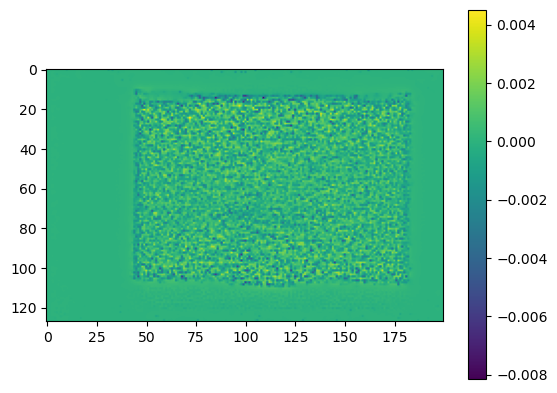

In [676]:
plt.imshow(recItV[18,:,100,:]-recItV[0,:,100,:])
plt.colorbar()

In [479]:
ss/ssDen

0.0

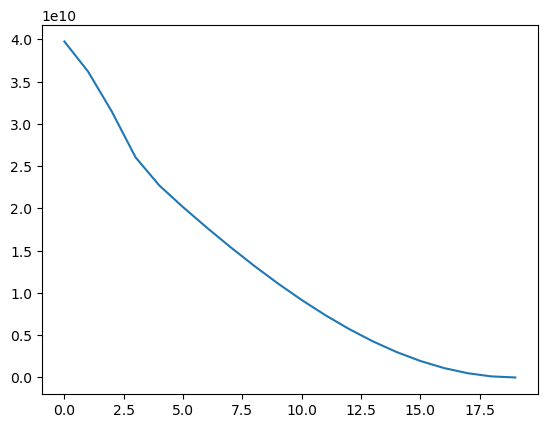

In [762]:
dV = np.sum(np.sum(np.sum(recItV-np.expand_dims(recItV[-1,:,:,:,],axis=0),axis=-1),axis=-1),axis=-1)**2
plt.plot(dV)

In [27]:
import scipy.ndimage as ndi

/tmp/ipykernel_11022/2359744373.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(sDir.as_array()[:,100,:]/kappa.as_array()[:,100,:],vmin=-0.00003,vmax=.00003)


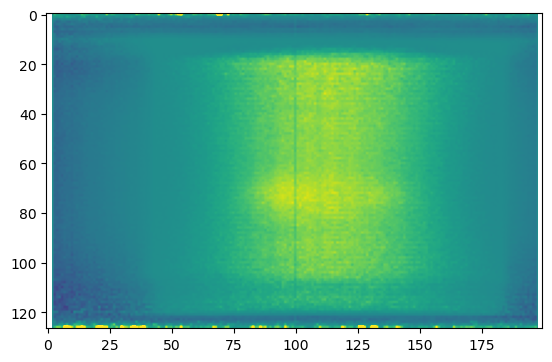

In [457]:
plt.imshow(sDir.as_array()[:,100,:]/kappa.as_array()[:,100,:],vmin=-0.00003,vmax=.00003)
#plt.colorbar()

/tmp/ipykernel_11022/2999593000.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(grad.as_array()[72,:,:]/kappa.as_array()[72,:,:]**2)
/tmp/ipykernel_11022/2999593000.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(grad.as_array()[72,:,:]/kappa.as_array()[72,:,:]**2)


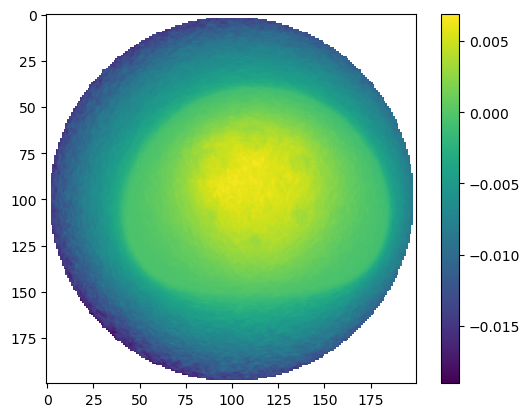

In [415]:

plt.imshow(grad.as_array()[72,:,:]/kappa.as_array()[72,:,:]**2)
plt.colorbar()

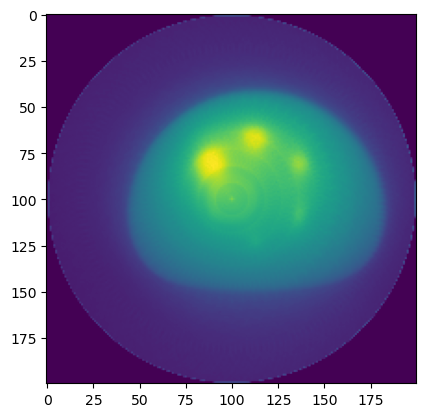

In [331]:
plt.imshow(bkwP.as_array()[72,:,:]/(kappa.as_array()[72,:,:]))